<a href="https://colab.research.google.com/github/yashkens/NN_methods/blob/main/NNmethods_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорты и загрузки

In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [1]:
!pip install transformers

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



In [3]:
import transformers
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup, EarlyStoppingCallback
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 6, 4

## Данные

In [5]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 57.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 233MB/s]


In [6]:
df = pd.read_csv("reviews.csv")
df.head(2)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo


In [7]:
# приведем пять классов к трем
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


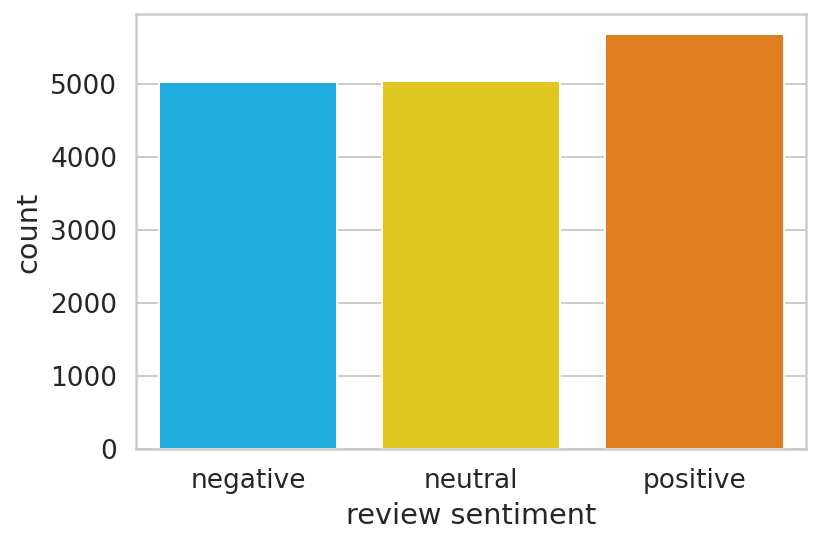

In [8]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)
plt.show()

## Загрузка токенизатора и модели

Я выбрала следующую бертоподобную модель, так как она была разработана для более удачных эмбеддингов предложений, а в нашем задании как раз классифицируются предложения, а не отдельные слова.

In [9]:
PRE_TRAINED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

In [10]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
# проверка, что токенизатор работает
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


## Создание датасета

In [12]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets):
    self.encodings = reviews
    self.labels = targets
  
  def __len__(self):
    return len(self.encodings["input_ids"])
  
  def __getitem__(self, ind):
      item = {key: torch.tensor(val[ind]) for key, val in self.encodings.items()}
      if self.labels:
          item["labels"] = torch.tensor(self.labels[ind])
      return item

In [13]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda', index=0)

In [14]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [15]:
MAX_LEN = 160

In [16]:
train_encodings = tokenizer(list(df_train.content), truncation=True, padding=True, max_length=MAX_LEN)
val_encodings = tokenizer(list(df_val.content), truncation=True, padding=True, max_length=MAX_LEN)
test_encodings = tokenizer(list(df_test.content), truncation=True, padding=True, max_length=MAX_LEN)

In [17]:
train_dataset = GPReviewDataset(train_encodings, list(df_train.sentiment))
val_dataset = GPReviewDataset(val_encodings, list(df_val.sentiment))
test_dataset = GPReviewDataset(test_encodings, list(df_test.sentiment))

In [18]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2018,  1037,  3291,  2007, 25925,  2000, 12882,  1012,
          2027,  2020,  4248,  2007,  2037,  3433,  1998,  4964,  1996,  3291,
          2157,  2185,  1012,  2009,  1005,  1055,  1037,  2204, 10439,  2005,
          2216,  5220,  2007,  1996,  5951, 11821,  2100,  2291,  1010,  1998,
         26351,  2015,  2092,  2408,  5733,  1012,   102,     0,     0,     0,
             0,     0,     0,

## Класс модели

In [43]:
# класс поверх класса BertModel
# (AutoModel в данном случае загрузит класс BertModel)

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.sent_bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.sent_bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    _, pooled_output = self.sent_bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      return_dict=False)
    output = self.drop(pooled_output) 
    output = self.out(output)
    device = input_ids.device

    loss_fn = nn.CrossEntropyLoss().to(device) # добавляю подсчет лосса в модель, чтобы Trainer работал как надо
    if labels is not None:
      loss = loss_fn(output, labels)
    else:
      return output
    return loss, output

In [44]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

loading configuration file https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/638ad0a5316af721f9c51d99b662379dfa3d511f9ac3fc035e54613c8581fc6a.e04b227431c36320dd2099e8f0d4f31a771996a92811dd8bcb453cc6291db001
Model config BertConfig {
  "_name_or_path": "sentence-transformers/all-MiniLM-L6-v2",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://

## Гиперпараметры и метрики для Trainer

Функция подсчета метрик и гиперпараметры не будут меняться для всех последующих заданий, чтобы результаты были сравнимы


In [23]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [24]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,  
    warmup_steps=500,               
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=100,
    load_best_model_at_end=True, # пусть загружает лучшую модель для финальной оценки
    evaluation_strategy='steps', # пусть проводит валидацию каждые 500 шагов
    save_strategy='steps',
    eval_steps=500
)

## Задание 1
Обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) - Обучение с помощью Trainer

In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,            
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # пусть останавливается, когда улучшения прекращаются
)

In [49]:
train_result = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.716700,0.685597,0.686150,0.676414,0.684012,0.674614
1000,0.610100,0.620218,0.720457,0.716433,0.721721,0.714328
1500,0.546800,0.605028,0.750953,0.745166,0.750553,0.743518


***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1500 (score: 0.6050283908843994).


In [50]:
trainer.log_metrics("train", train_result.metrics)

***** train metrics *****
  epoch                    =        2.0
  total_flos               =        0GF
  train_loss               =     0.6751
  train_runtime            = 0:06:05.50
  train_samples_per_second =     77.542
  train_steps_per_second   =      4.848


In [51]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.7509529860228716,
 'eval_f1': 0.7451662353075917,
 'eval_loss': 0.6050283908843994,
 'eval_precision': 0.7505525942553773,
 'eval_recall': 0.7435175867356719,
 'eval_runtime': 3.4684,
 'eval_samples_per_second': 226.904,
 'eval_steps_per_second': 14.416}

In [52]:
test_res = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


In [53]:
print('Test metrics')
print('')
print('Accuracy: {:.3f}'.format(test_res['test_accuracy']))
print('F1: {:.3f}'.format(test_res['test_f1']))
print('Precision: {:.3f}'.format(test_res['test_precision']))
print('Recall: {:.3f}'.format(test_res['test_recall']))

Test metrics

Accuracy: 0.731
F1: 0.726
Precision: 0.736
Recall: 0.726


#### Протестируем на трех отзывах из Google play
Отзывы в порядке 3 звезды, 5 звезд, 1 звезда, то есть neutral, positive, negative

In [54]:
# 3 звезды, 5 звезд, 1 звезда

reviews = ["""While yes it is calming and soothing to play...for the most part. It's not all that. Zen mode is nice and all bit most gamers want a challenge. This is a collecting gems kind of game. Sound track is great. Game play is cool, in a speed run way. With that in mind it is very fast paced for a "relaxing...""",
           """My offical favorite mobile game, the music and art style is fantastic! I hope there are more games like this to come in the future.""",
           """The game was great at the beginning. Then, the game bombards you with every single ad that they can placed at any place where they could place an ad. Be ready to watch 15-30 second unskippable as after every action."""]

In [59]:
def get_sentiment(review):
  encoded_review = tokenizer.encode_plus(review,
                          max_length=MAX_LEN,
                          add_special_tokens=True,
                          return_token_type_ids=True,
                          padding='max_length',
                          return_attention_mask=True,
                          return_tensors='pt',
                          truncation=True)
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  token_type_ids = encoded_review['token_type_ids'].to(device)
  output = model(input_ids, attention_mask, token_type_ids, None)
  prediction = torch.argmax(output, dim=1)
  return class_names[prediction]

In [61]:
for text in reviews:
  sentiment = get_sentiment(text)
  print(f'Text: {text}')
  print(f'Sentiment: {sentiment}')
  print('-'*10)

Text: While yes it is calming and soothing to play...for the most part. It's not all that. Zen mode is nice and all bit most gamers want a challenge. This is a collecting gems kind of game. Sound track is great. Game play is cool, in a speed run way. With that in mind it is very fast paced for a "relaxing...
Sentiment: positive
----------
Text: My offical favorite mobile game, the music and art style is fantastic! I hope there are more games like this to come in the future.
Sentiment: positive
----------
Text: The game was great at the beginning. Then, the game bombards you with every single ad that they can placed at any place where they could place an ad. Be ready to watch 15-30 second unskippable as after every action.
Sentiment: negative
----------


## Задание 2
Измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя

In [62]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.sent_bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    # теперь в последний слой передается в 2 раза больше параметров, так как
    # мы теперь берем не только выход с пуллер-слоя, но и с cls-токена последнего слоя
    self.out = nn.Linear(self.sent_bert.config.hidden_size * 2, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    # теперь будет необходим последний скрытый слой, запишем его в нормальную переменную
    last_hidden_state, pooled_output = self.sent_bert(  
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      return_dict=False)
    cls_hidden_states = last_hidden_state[:,0,:] # беру эмбеддинги первых токенов с последнего слоя для всех элементов в батче
    output = torch.cat((pooled_output, cls_hidden_states), dim=1) # объединяю с выходом из пуллер-слоя
    output = self.drop(output) # и подаю дальше объединенные параметры (теперь их там в 2 раза больше)
    output = self.out(output)
    device = input_ids.device

    loss_fn = nn.CrossEntropyLoss().to(device)
    if labels is not None:
      loss = loss_fn(output, labels)
    else:
      return output
    return loss, output

In [63]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

loading configuration file https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/638ad0a5316af721f9c51d99b662379dfa3d511f9ac3fc035e54613c8581fc6a.e04b227431c36320dd2099e8f0d4f31a771996a92811dd8bcb453cc6291db001
Model config BertConfig {
  "_name_or_path": "sentence-transformers/all-MiniLM-L6-v2",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://

In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,            
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [65]:
train_result = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.717300,0.682986,0.689962,0.684335,0.696784,0.680915
1000,0.589200,0.622687,0.729352,0.725786,0.732433,0.723729
1500,0.541600,0.621370,0.735705,0.729154,0.737171,0.727484


***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1500 (score: 0.6213703751564026).


In [66]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.735705209656925,
 'eval_f1': 0.729154392858734,
 'eval_loss': 0.6213703751564026,
 'eval_precision': 0.7371705023527192,
 'eval_recall': 0.7274839167625071,
 'eval_runtime': 3.4614,
 'eval_samples_per_second': 227.367,
 'eval_steps_per_second': 14.445}

In [67]:
test_res = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


In [68]:
print('Test metrics')
print('')
print('Accuracy: {:.3f}'.format(test_res['test_accuracy']))
print('F1: {:.3f}'.format(test_res['test_f1']))
print('Precision: {:.3f}'.format(test_res['test_precision']))
print('Recall: {:.3f}'.format(test_res['test_recall']))

Test metrics

Accuracy: 0.730
F1: 0.725
Precision: 0.738
Recall: 0.724


Почти ничего не поменялось, но качество стало чуть пониже.  
Accuracy упала с 0.731 до 0.730  
F1 с 0.736 до 0.735  


In [69]:
for text in reviews:
  sentiment = get_sentiment(text)
  print(f'Text: {text}')
  print(f'Sentiment: {sentiment}')
  print('-'*10)

Text: While yes it is calming and soothing to play...for the most part. It's not all that. Zen mode is nice and all bit most gamers want a challenge. This is a collecting gems kind of game. Sound track is great. Game play is cool, in a speed run way. With that in mind it is very fast paced for a "relaxing...
Sentiment: positive
----------
Text: My offical favorite mobile game, the music and art style is fantastic! I hope there are more games like this to come in the future.
Sentiment: positive
----------
Text: The game was great at the beginning. Then, the game bombards you with every single ad that they can placed at any place where they could place an ad. Be ready to watch 15-30 second unskippable as after every action.
Sentiment: negative
----------


## Задание 3
Примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification)

In [70]:
# загружаю готовый класс и конфиг, чтобы его поменять

from transformers import BertForSequenceClassification, BertConfig
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)

loading configuration file https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/638ad0a5316af721f9c51d99b662379dfa3d511f9ac3fc035e54613c8581fc6a.e04b227431c36320dd2099e8f0d4f31a771996a92811dd8bcb453cc6291db001
Model config BertConfig {
  "_name_or_path": "nreimers/MiniLM-L6-H384-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [71]:
# меняю количество классов в конфиге
config.num_labels = len(class_names)

In [74]:
# загружаю модель с помощью готового класса и измененного конфига
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
model = model.to(device)

loading weights file https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b83bfc481e9d88e36fd72a3b8bb3bd577568db0daf213e4cd0a94ac3a2f4dfa2.7df9d891b064d501e82f94319f749bc86f649d1b7d7308a3db7f167b1377df79
All model checkpoint weights were used when initializing BertForSequenceClassification.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,            
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [76]:
train_result = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.719000,0.678852,0.684879,0.677463,0.687039,0.674657
1000,0.607100,0.619983,0.724269,0.719207,0.722442,0.717945
1500,0.556300,0.616797,0.742058,0.736083,0.745513,0.734167


***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1500 (score: 0.6167969703674316).


In [77]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.7420584498094028,
 'eval_f1': 0.7360826822653816,
 'eval_loss': 0.6167969703674316,
 'eval_precision': 0.7455130510471069,
 'eval_recall': 0.7341674453709027,
 'eval_runtime': 3.4086,
 'eval_samples_per_second': 230.883,
 'eval_steps_per_second': 14.669}

In [78]:
test_res = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


In [79]:
print('Test metrics\n')
print('Accuracy: {:.3f}'.format(test_res['test_accuracy']))
print('F1: {:.3f}'.format(test_res['test_f1']))
print('Precision: {:.3f}'.format(test_res['test_precision']))
print('Recall: {:.3f}'.format(test_res['test_recall']))

Test metrics

Accuracy: 0.723
F1: 0.719
Precision: 0.733
Recall: 0.719


Метрики ниже, чем у двух предыдущих версий, но не на много.  
Accuracy первой модели 0.731, этой 0.723  
F1 первой модели 0.726, этой 0.719  

Чтобы посмотреть на три примера придется немного поменять функцию для применения модели

In [90]:
def get_sentiment_ready_model(review):
  encoded_review = tokenizer.encode_plus(review,
                          max_length=MAX_LEN,
                          add_special_tokens=True,
                          return_token_type_ids=True,
                          padding='max_length',
                          return_attention_mask=True,
                          return_tensors='pt',
                          truncation=True)
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  token_type_ids = encoded_review['token_type_ids'].to(device)
  output = model(input_ids, attention_mask, token_type_ids, None)
  prediction = torch.argmax(output['logits'], dim=1) # другой аутпут у модели, поэтому меняю эту строку
  return class_names[prediction]

In [92]:
for text in reviews:
  sentiment = get_sentiment_ready_model(text)
  print(f'Text: {text}')
  print(f'Sentiment: {sentiment}')
  print('-'*10)

Text: While yes it is calming and soothing to play...for the most part. It's not all that. Zen mode is nice and all bit most gamers want a challenge. This is a collecting gems kind of game. Sound track is great. Game play is cool, in a speed run way. With that in mind it is very fast paced for a "relaxing...
Sentiment: positive
----------
Text: My offical favorite mobile game, the music and art style is fantastic! I hope there are more games like this to come in the future.
Sentiment: positive
----------
Text: The game was great at the beginning. Then, the game bombards you with every single ad that they can placed at any place where they could place an ad. Be ready to watch 15-30 second unskippable as after every action.
Sentiment: negative
----------


## Задание 4
Агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса

In [94]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.sent_bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.sent_bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    last_hidden, pooled_output, hidden = self.sent_bert( # теперь возвращается три переменные, включая все скрытые слои
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      return_dict=False,
      output_hidden_states=True) # меняю параметр, чтобы возвращались все слои
    all_hidden_cls = [layer[:,0,:] for layer in hidden] # собираю эмбеддинги cls токенов со всех скрытых слоев
    cls_mean = torch.mean(torch.stack(all_hidden_cls, dim=0), dim=0) # беру среднее от них
    output = self.drop(cls_mean) # отправляю в модель
    output = self.out(output)
    device = input_ids.device

    loss_fn = nn.CrossEntropyLoss().to(device)
    if labels is None:
      return output
    loss = loss_fn(output, labels)
    return loss, output

In [95]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

loading configuration file https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/638ad0a5316af721f9c51d99b662379dfa3d511f9ac3fc035e54613c8581fc6a.e04b227431c36320dd2099e8f0d4f31a771996a92811dd8bcb453cc6291db001
Model config BertConfig {
  "_name_or_path": "sentence-transformers/all-MiniLM-L6-v2",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://

In [96]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,            
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [97]:
train_result = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.757300,0.704029,0.686150,0.675424,0.677156,0.674563
1000,0.655700,0.633712,0.720457,0.715023,0.718778,0.713335
1500,0.583000,0.598635,0.736976,0.730205,0.734257,0.728616


***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1500 (score: 0.5986348390579224).


In [98]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.7369758576874206,
 'eval_f1': 0.7302051081898581,
 'eval_loss': 0.5986348390579224,
 'eval_precision': 0.7342566828024327,
 'eval_recall': 0.7286157334195899,
 'eval_runtime': 3.4604,
 'eval_samples_per_second': 227.432,
 'eval_steps_per_second': 14.449}

In [99]:
test_res = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


In [100]:
print('Test metrics\n')
print('Accuracy: {:.3f}'.format(test_res['test_accuracy']))
print('F1: {:.3f}'.format(test_res['test_f1']))
print('Precision: {:.3f}'.format(test_res['test_precision']))
print('Recall: {:.3f}'.format(test_res['test_recall']))

Test metrics

Accuracy: 0.720
F1: 0.715
Precision: 0.725
Recall: 0.714


Эта модель показала самые плохие метрики.

In [101]:
for text in reviews:
  sentiment = get_sentiment(text)
  print(f'Text: {text}')
  print(f'Sentiment: {sentiment}')
  print('-'*10)

Text: While yes it is calming and soothing to play...for the most part. It's not all that. Zen mode is nice and all bit most gamers want a challenge. This is a collecting gems kind of game. Sound track is great. Game play is cool, in a speed run way. With that in mind it is very fast paced for a "relaxing...
Sentiment: positive
----------
Text: My offical favorite mobile game, the music and art style is fantastic! I hope there are more games like this to come in the future.
Sentiment: positive
----------
Text: The game was great at the beginning. Then, the game bombards you with every single ad that they can placed at any place where they could place an ad. Be ready to watch 15-30 second unskippable as after every action.
Sentiment: negative
----------


## Задание 5 
смотрите в остальных заданиях - каждая из предыдущих моделей тестируется на трех выбранных отзывах из google play

Каждая модель одинаково распределила эти три отзыва: все верно определили негативный и положительный отзыв, но нейтральный отзыв всегда неверно получался положительным.

Выбранный мной нейтральный отзыв не самый простой случай - если бы я не знала, что у него три звезды, я бы сама не знала, к какому классу его отнести.

К сожалению, у меня не получилось второй раз открыть отзывы google play именно на английском... Простите меня, я не очень уверенный пользователь google play 😬 